In [136]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle
import pandas as pd
from scipy.ndimage import gaussian_filter

In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
DATA_FOLDER = "../figure_6/data/"

height_ratios_scaling: [2, 3, 2, 2]


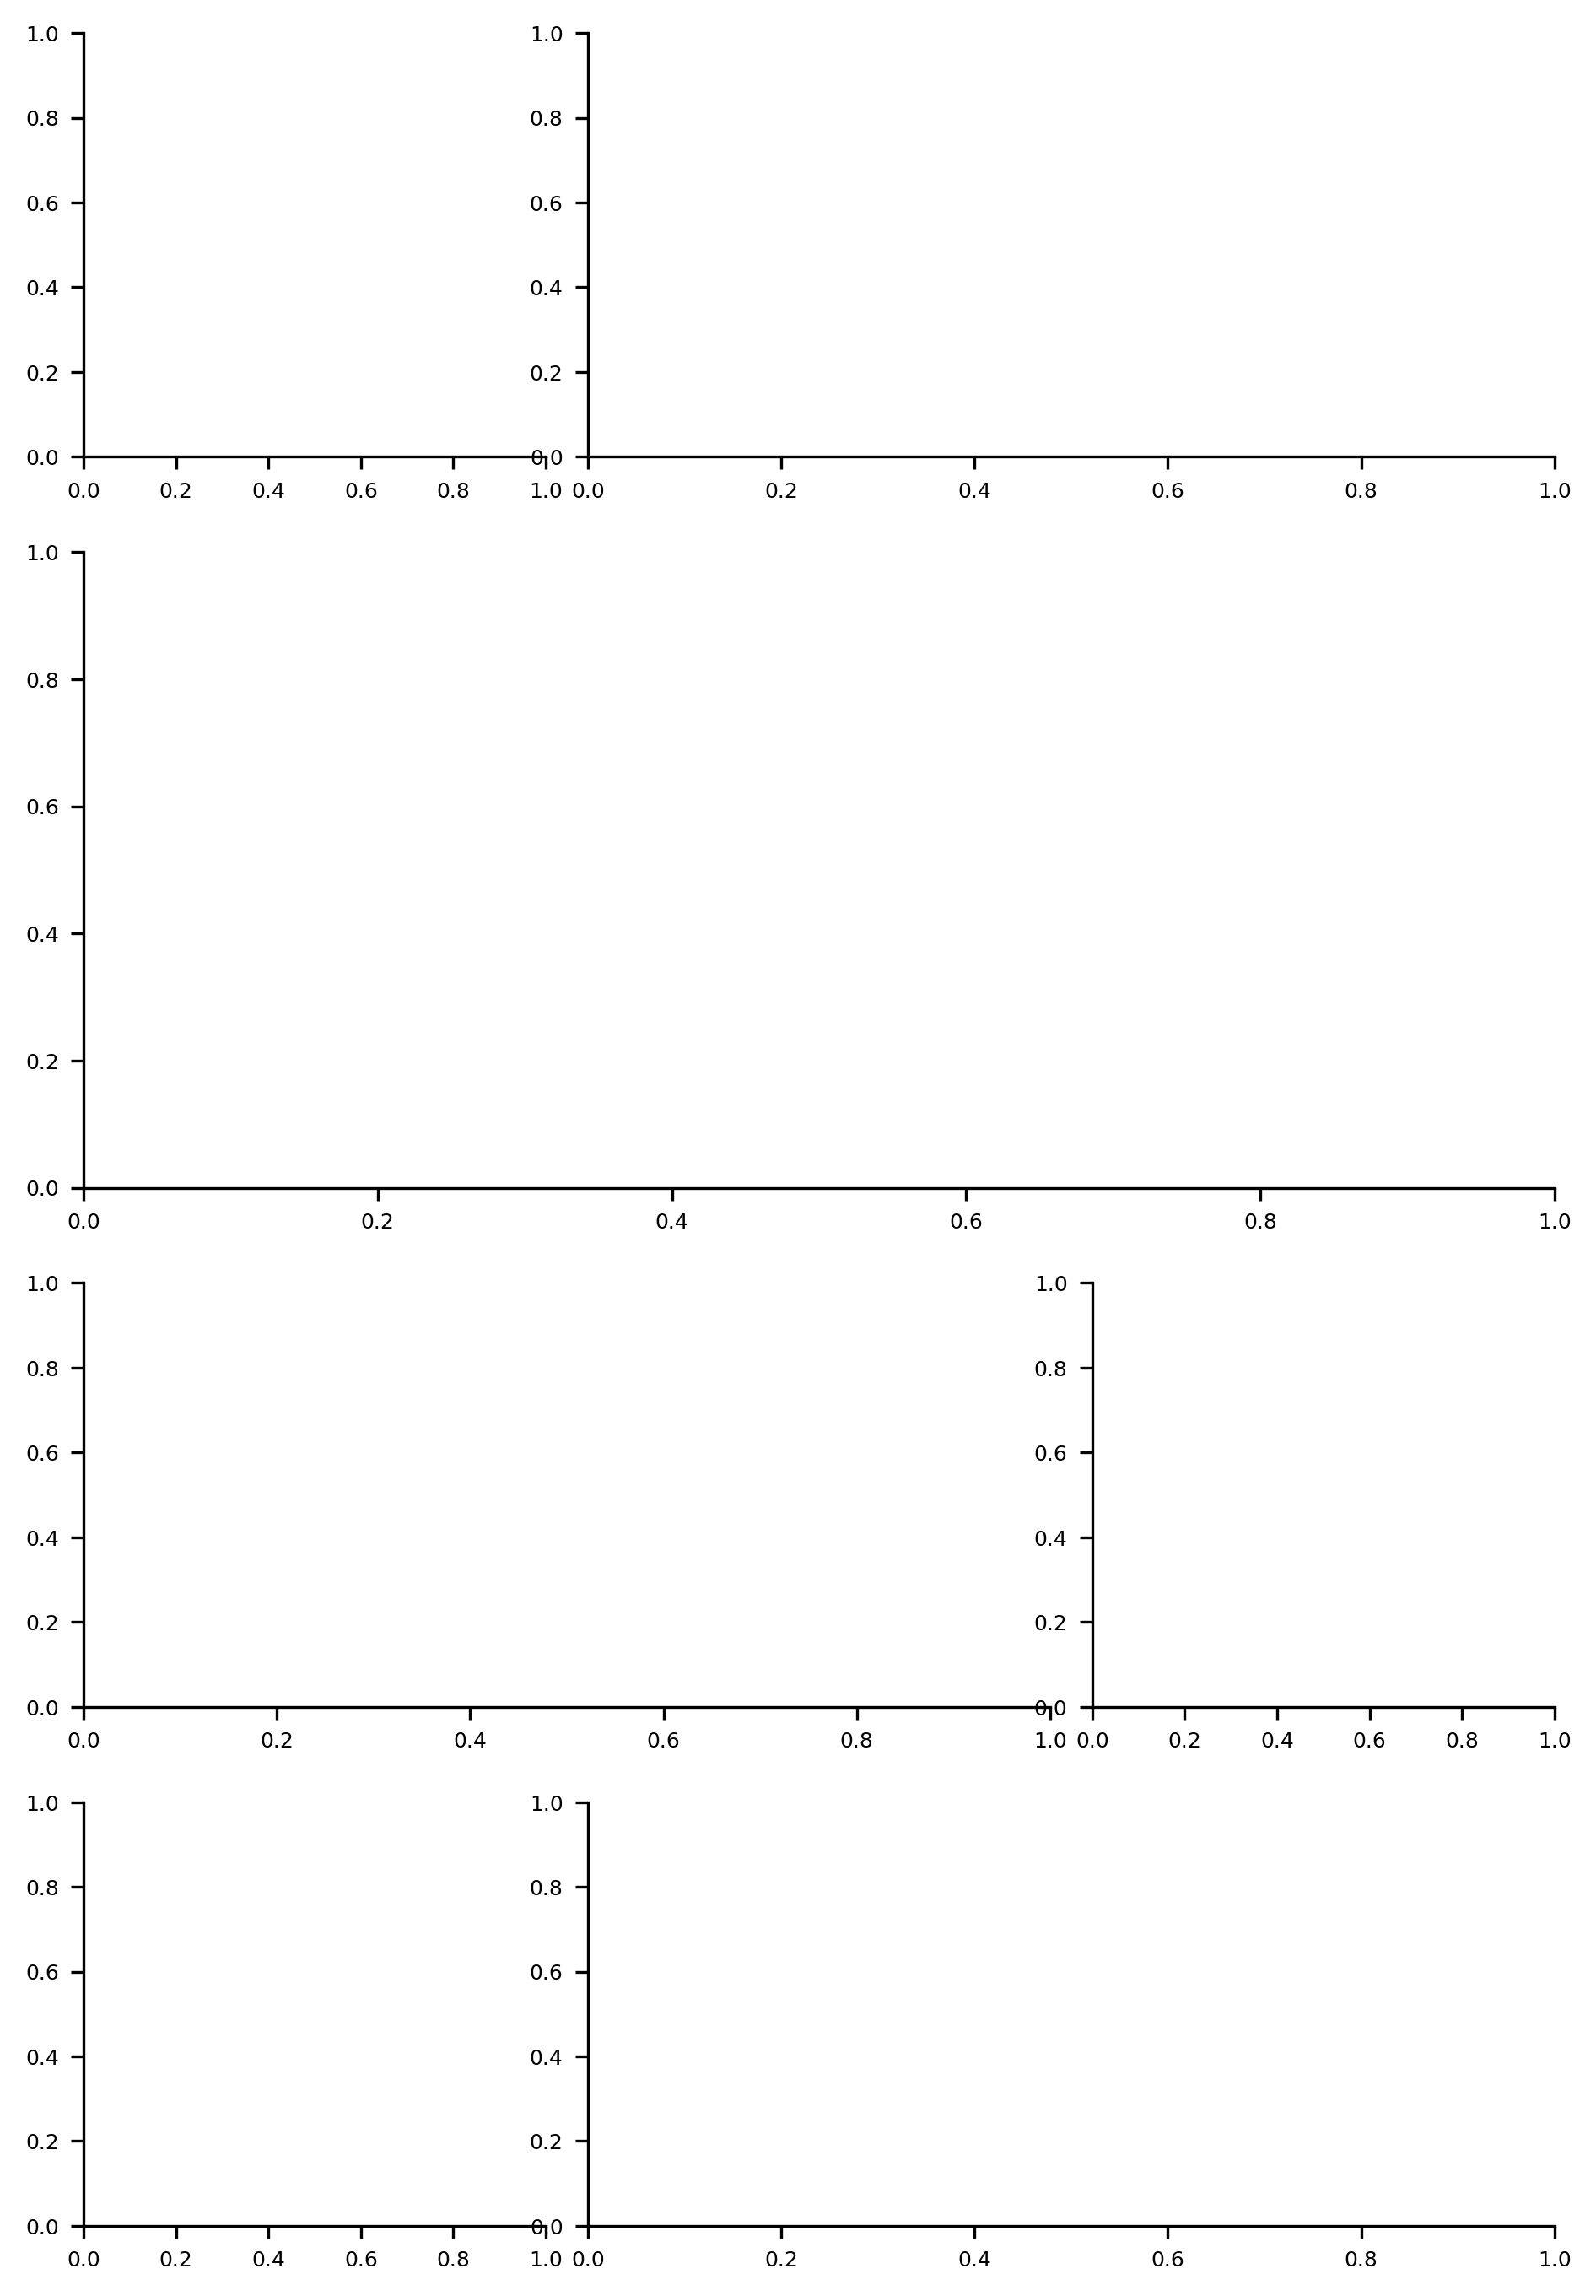

In [139]:
mosaic = [["A", "B", "B"], ["C", "C"], ["D", "D", "E"], ["F", "G", "G"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [140]:
DATA_FOLDER_ADATA = "../../../data/"
adata = anndata.read_h5ad(
    f"{DATA_FOLDER_ADATA}/somite/mesodermal_progenitors_Tbx6p_names_mapped_2.h5ad"
)
i_cycling = adata.obs["cycling"]
adata_all = adata.copy()
adata = adata[i_cycling]

In [141]:
somite = pickle.load(open(os.path.join(DATA_FOLDER, "somite_res.pkl"), "rb"))
somite["projected_z"][:, 1] = somite["projected_z"][:, 1]
shift = 1.5
somite["thetas"] = utils.normalize_angles(somite["thetas"] - shift)

In [142]:
def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def get_genes_fractions(gene_names, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (adata[:, gene_names].layers[layer].toarray().T / library_size).T
    return gene_fractions


def plot_gene_profiles(
    gene_names,
    adata,
    inferred_phase,
    axs,
    position,
    layer="total",
    hue=None,
    legend_title=None,
    x_label="Inferred Phase",
):
    try:
        axs = plot_helpers.replace_mosaic_cell_with_grid(
            fig, axs, label=position, nrows=1, ncols=len(gene_names)
        )
    except:
        pass
    for i in range(len(gene_names)):
        gene_name = gene_names[i]
        gene_fractions = get_gene_fractions(gene_name, adata, layer=layer)
        _, axs[position][i] = plotting.modify_axis_labels(ax=axs[position][i], step=0.5)

        plotting.plot_smoothed_profiles(
            inferred_phase,
            np.log(gene_fractions * 1e4 + 1),
            ax=axs[position][i],
            nbins=20,
            xlabel=x_label,
            ylabel=f"Normalized Counts (log)" if i == 0 else None,
            legend=i == len(gene_names) - 1,
            hue=hue,
        )
        # set title in italic and bold
        axs[position][i].set_title(gene_name, fontstyle="italic", fontweight="bold")
        if i == len(gene_names) - 1 and legend_title is not None:
            axs[position][i].legend(title=legend_title)

In [143]:
from matplotlib.colors import TwoSlopeNorm


def modify_axis_labels(ax, x, y, n_bins):
    rad = ""
    if np.max(abs(x)) <= np.pi:
        ax.set_xticks([-np.pi, np.pi])
        ax.set_xticklabels(["-π", "π"])
        x_bin_edges = np.linspace(-np.pi, np.pi, n_bins, endpoint=True)
    else:
        ax.set_xticks([])
        x_bin_edges = np.linspace(np.min(x), np.max(x), n_bins)
    if np.max(abs(y)) <= np.pi:
        ax.set_yticks([-np.pi, np.pi])
        ax.set_yticklabels(["-π", "π"])
        y_bin_edges = np.linspace(-np.pi, np.pi, n_bins, endpoint=True)
    else:
        ax.set_yticks([])
        y_bin_edges = np.linspace(np.min(y), np.max(y), n_bins)
    return (x_bin_edges, y_bin_edges)


def compute_PMI(x, y, bins, sigma):
    # Compute 2D histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # Circular Gaussian smoothing
    H_smooth = gaussian_filter(H, sigma=(sigma, sigma), mode="wrap")

    # Normalize along x-axis (each column sums to 1)
    eps = 1e-9  # small constant to avoid log(0)

    Px = H_smooth.sum(axis=1, keepdims=True)
    Py = H_smooth.sum(axis=0, keepdims=True)

    Pxy = H_smooth / H_smooth.sum()
    Px = Px / H_smooth.sum()
    Py = Py / H_smooth.sum()

    PMI = np.log2((Pxy + eps) / (Px @ Py + eps))
    return PMI, xedges, yedges


def plot_PMI(
    x,
    y,
    ax,
    n_bins=10,
    sigma=0.5,
    double_plot=False,
    min_value=np.log2(1.5),
    add_cbar=True,
):
    bins = modify_axis_labels(ax, x, y, n_bins)
    PMI, xedges, yedges = compute_PMI(x, y, bins, sigma)
    if double_plot:
        PMI = np.hstack((np.vstack((PMI, PMI)), np.vstack((PMI, PMI))))
        xedges = np.concatenate((xedges, xedges[:-1] + np.max(xedges)))
        yedges = np.concatenate((yedges, yedges[:-1] + 2 * np.pi))

    vmin = min(-min_value, np.min(PMI))
    vmax = max(min_value, np.max(PMI))

    norm = TwoSlopeNorm(
        vmin=vmin,
        vcenter=0.0,
        vmax=vmax,
    )

    im = ax.pcolormesh(
        xedges,
        yedges,
        PMI.T,
        cmap="coolwarm",
        norm=norm,
    )
    if add_cbar:
        divider = make_axes_locatable(ax)
        ax_cbar = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(
            im,
            cax=ax_cbar,
            orientation="vertical",
        )
        cbar.outline.set_visible(False)
        cbar.set_ticks([np.min(PMI), 0, np.max(PMI)])
        # set labels as round numbers
        cbar.set_ticklabels(
            [f"{np.round(np.min(PMI), 1)}", "0", f"{np.round(np.max(PMI), 1)}"]
        )


def line_cost(offset, xedges, yedges, PMI, sigma=0.1):
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")  # shape matches PMI

    # slope wraps 2π over x range
    m = 2 * np.pi / (xedges[-1] - xedges[0])

    # circular difference
    Y_shifted = (Y - (m * X + offset) + np.pi) % (2 * np.pi) - np.pi

    # Gaussian weight
    W = np.exp(-(Y_shifted**2) / (2 * sigma**2))

    # want to align with positive PMI, avoid negative PMI
    cost = -np.sum(PMI * W)
    return cost

In [144]:
categories = [str(i) for i in range(12)]

# initialize as categorical with all possible labels
adata.obs["post_ant_model"] = pd.Categorical(
    values=[np.nan] * adata.n_obs,
    categories=categories,
)
cat_dtype = adata.obs["post_ant_model"].dtype

for emb in adata.obs["embryo_id"].unique():
    i = adata.obs["embryo_id"] == emb
    adata.obs.loc[i, "post_ant_model"] = pd.qcut(
        somite["projected_z"][i, 1],
        q=12,
        labels=categories,
    ).astype(cat_dtype)

/tmp/ipykernel_561714/68983726.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["post_ant_model"] = pd.Categorical(


In [145]:
adata.var_names[adata.var_names.str.contains("Gsk")]

Index(['Gsk3a', 'Gskip', 'Gsk3b'], dtype='object', name='gene_symbols')

In [146]:
import tqdm

df_tmp = pd.DataFrame(index=somite["gene_names"] + ["Axin2", "Gsk3a", "Gsk3b"])
for g in tqdm.tqdm(df_tmp.index):
    i = adata.obs["post_ant_model"].astype(int) > 7
    res = pearsonr(
        np.log(1 + get_gene_fractions(g, adata)[i] * 10**4),
        np.log(1 + get_gene_fractions("Hes7", adata)[i] * 10**4),
    )
    df_tmp.loc[g, "correlation_ant"] = res[0]
    df_tmp.loc[g, "correlation_ant_pval"] = res[1]
    i = adata.obs["post_ant_model"].astype(int) < 4
    res = pearsonr(
        np.log(1 + get_gene_fractions(g, adata)[i] * 10**4),
        np.log(1 + get_gene_fractions("Hes7", adata)[i] * 10**4),
    )
    df_tmp.loc[g, "correlation_post"] = res[0]
    df_tmp.loc[g, "correlation_post_pval"] = res[1]

  0%|          | 0/165 [00:00<?, ?it/s]

100%|██████████| 165/165 [00:45<00:00,  3.60it/s]


In [147]:
# sort by max abs correlation
df_tmp["max_abs_correlation"] = (
    df_tmp[["correlation_ant", "correlation_post"]].abs().max(axis=1)
)
df_tmp = df_tmp.sort_values(by="max_abs_correlation", ascending=False)
df_tmp.head(10)

,correlation_ant,correlation_ant_pval,correlation_post,correlation_post_pval,max_abs_correlation
Hes7,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000
Lfng,0.384699,6.402774e-294,0.329253,3.504807e-211,0.384699
Hes5,0.194204,4.652942e-72,0.069549,1.825181e-10,0.194204
Dkk1,-0.101955,8.048672e-21,-0.186279,2.403242e-66,0.186279
Efna1,0.122135,3.100820e-29,0.169371,5.330298e-55,0.169371
Dll1,0.139745,7.795897e-38,0.162397,1.189844e-50,0.162397
Per1,0.140882,1.975622e-38,0.130414,3.942615e-33,0.140882
Pdzrn3,-0.063031,7.621651e-09,-0.128515,3.252262e-32,0.128515
Hes1,0.115871,1.847821e-26,0.124880,1.692745e-30,0.124880
Dusp4,0.119782,3.560390e-28,0.071349,6.121397e-11,0.119782


In [148]:
df_tmp["difference"] = (df_tmp["correlation_ant"] - df_tmp["correlation_post"]).abs()
df_tmp.sort_values(by="difference", ascending=False).head(10)

,correlation_ant,correlation_ant_pval,correlation_post,correlation_post_pval,max_abs_correlation,difference
Axin2,0.060850,2.456325e-08,-0.077466,1.219387e-12,0.077466,0.138316
Hes5,0.194204,4.652942e-72,0.069549,1.825181e-10,0.194204,0.124655
Gse1,0.103749,1.658023e-21,-0.004073,7.091903e-01,0.103749,0.107822
Kcnk10,0.000700,9.489222e-01,0.087573,9.491094e-16,0.087573,0.086873
Dkk1,-0.101955,8.048672e-21,-0.186279,2.403242e-66,0.186279,0.084324
Pknox2,0.044408,4.745365e-05,-0.036680,7.811539e-04,0.044408,0.081088
Msx1,0.049371,6.097999e-06,-0.029593,6.727969e-03,0.049371,0.078964
Tle1,0.087777,8.142068e-16,0.010539,3.345699e-01,0.087777,0.077238
Tle3,0.053073,1.158435e-06,-0.019819,6.955949e-02,0.053073,0.072893
Pdzrn3,-0.063031,7.621651e-09,-0.128515,3.252262e-32,0.128515,0.065484


In [149]:
df_tmp.loc[["Axin2", "Dkk1"]]

,correlation_ant,correlation_ant_pval,correlation_post,correlation_post_pval,max_abs_correlation,difference
Axin2,0.060850,2.456325e-08,-0.077466,1.219387e-12,0.077466,0.138316
Dkk1,-0.101955,8.048672e-21,-0.186279,2.403242e-66,0.186279,0.084324


In [150]:
# plot in heatmap the Axin2 vs Hes7 correlation in post and ant in one row, and in the second row Dkk1 vs Hes7 correlation in post and ant.
df_tmp = df_tmp.loc[["Axin2", "Dkk1"]]
ax = axs["A"]
sns.heatmap(
    df_tmp[["correlation_post", "correlation_ant"]],
    annot=True,
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Pearson Correlation"},
    fmt=".2f",
    xticklabels=["Posterior", "Anterior"],
    yticklabels=["Axin2", "Dkk1"],
    cbar=False,
    ax=ax,
)

<Axes: label='A'>

In [151]:
ax = axs["B"]
plot_gene_profiles(
    ["Per1", "Bmal1", "Dbp"],
    adata,
    somite["thetas"],
    axs,
    position="B",
    layer="total",
)

In [152]:
from scipy.optimize import minimize_scalar

results = {}
for id in adata.obs["embryo_id"].unique():
    i = adata.obs["embryo_id"] == id
    PMI, xedges, yedges = compute_PMI(
        adata.obs.loc[i, "post_ant_model"].astype(int),
        somite["thetas"][i],
        bins=10,
        sigma=1,
    )
    res = minimize_scalar(
        lambda b: line_cost(b, xedges, yedges, PMI, sigma=0.5),
        bounds=(-2 * np.pi, 2 * np.pi),
        method="bounded",
    )
    optimal_offset = res.x
    results[id] = utils.normalize_angles(optimal_offset)

In [153]:
results = pd.DataFrame.from_dict(
    results, orient="index", columns=["optimal_offset"]
).sort_values(by="optimal_offset")
axs = plot_helpers.replace_mosaic_cell_with_grid(fig, axs, label="C", nrows=2, ncols=4)
for i, id in enumerate(results.index[::4][::-1]):
    ii = adata.obs["embryo_id"] == id
    PMI, xedges, yedges = compute_PMI(
        adata.obs.loc[ii, "post_ant_model"].astype(int),
        somite["thetas"][ii],
        bins=10,
        sigma=1,
    )
    ax = axs["C"][i]
    plot_PMI(
        adata.obs.loc[ii, "post_ant_model"].astype(int),
        somite["thetas"][ii],
        ax=ax,
        n_bins=10,
        sigma=1,
        add_cbar=False,
    )
    m = 2 * np.pi / (xedges[-1] - xedges[0])
    optimal_offset = results.loc[id, "optimal_offset"]
    x = np.linspace(xedges[0], xedges[-1], 100)
    y = (m * x + optimal_offset + np.pi) % (2 * np.pi) - np.pi

    # Detect wrap-around jumps
    dy = np.diff(y)
    y[np.where(np.abs(dy) > np.pi)] = np.nan

    ax.plot(x, y, "black", lw=1.5)

    if not i % 4:
        ax.set_ylabel("Somite Phase")
    else:
        ax.set_yticks([])
    if i > 3:
        ax.set_xlabel("Posterior-Anterior")

In [154]:
adata.obs["embryo_id"]

run_4_P2-01A.CGTCTTCCTTAGGCCATAG-0            embryo_7
run_4_P2-01A.CGTTGATCTCTTGGTAATG-0            embryo_9
run_4_P2-01A.AATACCGAATGGCGAACTCG-0          embryo_10
run_4_P2-01A.CGTAGGCTTTTAGGACCGG-0           embryo_12
run_4_P2-01A.AGGCTCGTTGTCCTACTTG-0            embryo_5
                                               ...    
run_17_PD-12H_S384.GTCTATGGTGGCTATGACT-2     embryo_31
run_17_PD-12H_S384.TTGAGTCCTTCAATCGCAT-2     embryo_27
run_17_PD-12H_S384.AACCGCTGTACGAGGACCT-2     embryo_31
run_17_PD-12H_S384.GATCGACCTTAACTGGTTA-2     embryo_26
run_17_PD-12H_S384.ATGGTAACTTCCATTATCTA-2    embryo_25
Name: embryo_id, Length: 25130, dtype: category
Categories (31, object): ['embryo_1', 'embryo_2', 'embryo_3', 'embryo_4', ..., 'embryo_28', 'embryo_29', 'embryo_30', 'embryo_31']

In [155]:
# open cell cycle results
cc_results = pickle.load(
    open(os.path.join(DATA_FOLDER, "chengxiang_cell_cycle_results.pkl"), "rb")
)
cc_results["inferred_theta"]

array([ 0.26361632, -1.1967854 ,  1.0943902 , ..., -1.9528079 ,
        2.473696  ,  1.9306271 ], dtype=float32)

In [156]:
ax = axs["D"]
plot_gene_profiles(
    ["Mcm6", "Pcna", "Top2a"],
    adata_all,
    cc_results["inferred_theta"],
    axs,
    position="D",
    layer="total",
    x_label="Cell Cycle Phase",
)

In [157]:
adata.var_names[adata.var_names.str.contains("As")]

Index(['Asnsd1', 'Asic4', 'Asb18', 'Asb1', 'Ascl5', 'Aspm', 'Astn1', 'Asb6',
       'Ass1', 'Astl', 'Asxl1', 'Asic5', 'Ash1l', 'Asb17', 'Asph', 'Astn2',
       'Asap3', 'Asic3', 'Asb10', 'Asphd2', 'Asl', 'Asb4', 'Asns', 'Asz1',
       'Asb15', 'Asprv1', 'Aspdh', 'Asb7', 'Ascl3', 'Asphd1', 'Ascl2', 'Ash2l',
       'Asah1', 'Asb5', 'Asf1b', 'Aste1', 'Ascc3', 'Asf1a', 'Ascc1', 'Ascl4',
       'Ascl1', 'Ascc2', 'Asb3', 'Asgr1', 'Asgr2', 'Aspa', 'Asic2', 'Asb16',
       'Aspscr1', 'Asxl2', 'Asap2', 'Asb2', 'Aspg', 'Asb13', 'Aspn', 'Asb14',
       'Asap1', 'Asb8', 'Asic1', 'Asxl3', 'Asrgl1', 'Asah2', 'As3mt'],
      dtype='object', name='gene_symbols')

In [158]:
ax = axs["E"]
plotting.modify_axis_labels(ax=ax, step=0.5)
# plot library size

library_size = adata_all.layers["total"].sum(axis=1).A1
plotting.plot_smoothed_profiles(
    x=utils.normalize_angles(cc_results["inferred_theta"]),
    y=library_size,
    ax=ax,
    xlabel="Cell Cycle Phase",
    ylabel="Mean #UMI",
    title="#UMI vs Cell Cycle Phase",
)

In [159]:
cc_results.keys()

dict_keys(['library_size', 'inferred_theta', 'histones_fraction', 'cell_indices', 'z_space', 'context_genes', 'cycling_genes', 'df_mean', 'df_rhythmic', 'df_z', 'f_space'])

In [160]:
axs = plot_helpers.make_polar(axs, "F")
plotting.plot_cell_cycle(cc_results["df_rhythmic"], ax=axs["F"])
# add a cycle line according to the phase bins
phase_bins = [
    (-0.25 * np.pi / 2, 0.25 * np.pi / 2, "G1", "#1f77b4"),
    (0.25 * np.pi / 2, 0.25 * np.pi, "G1/S", "#ff7f0e"),
    (0.25 * np.pi, np.pi, "S", "#2ca02c"),
    (-np.pi, -0.75 * np.pi, "S", "#2ca02c"),
    (-0.75 * np.pi, -0.5 * np.pi, "G2", "#d62728"),
    (-0.5 * np.pi, -0.25 * np.pi / 2, "M", "#8c564b"),
]
ax = axs["F"]
amp = 1
for start, end, label, color in phase_bins:
    theta = np.linspace(start, end, 100)
    r = np.full_like(theta, amp)
    ax.plot(theta, r, color=color, lw=2, solid_capstyle="butt")

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


In [161]:
ax = axs["G"]
plot_gene_profiles(
    ["Dkk1", "Axin2", "Hes7"],
    adata,
    cc_results["inferred_theta"][i_cycling],
    axs,
    position="G",
    layer="total",
    x_label="Cell Cycle Phase",
)

Figure saved to: /home/maxine/Documents/paychere/CoPhaser/paper/figures/figure_S10_somite_python.svg


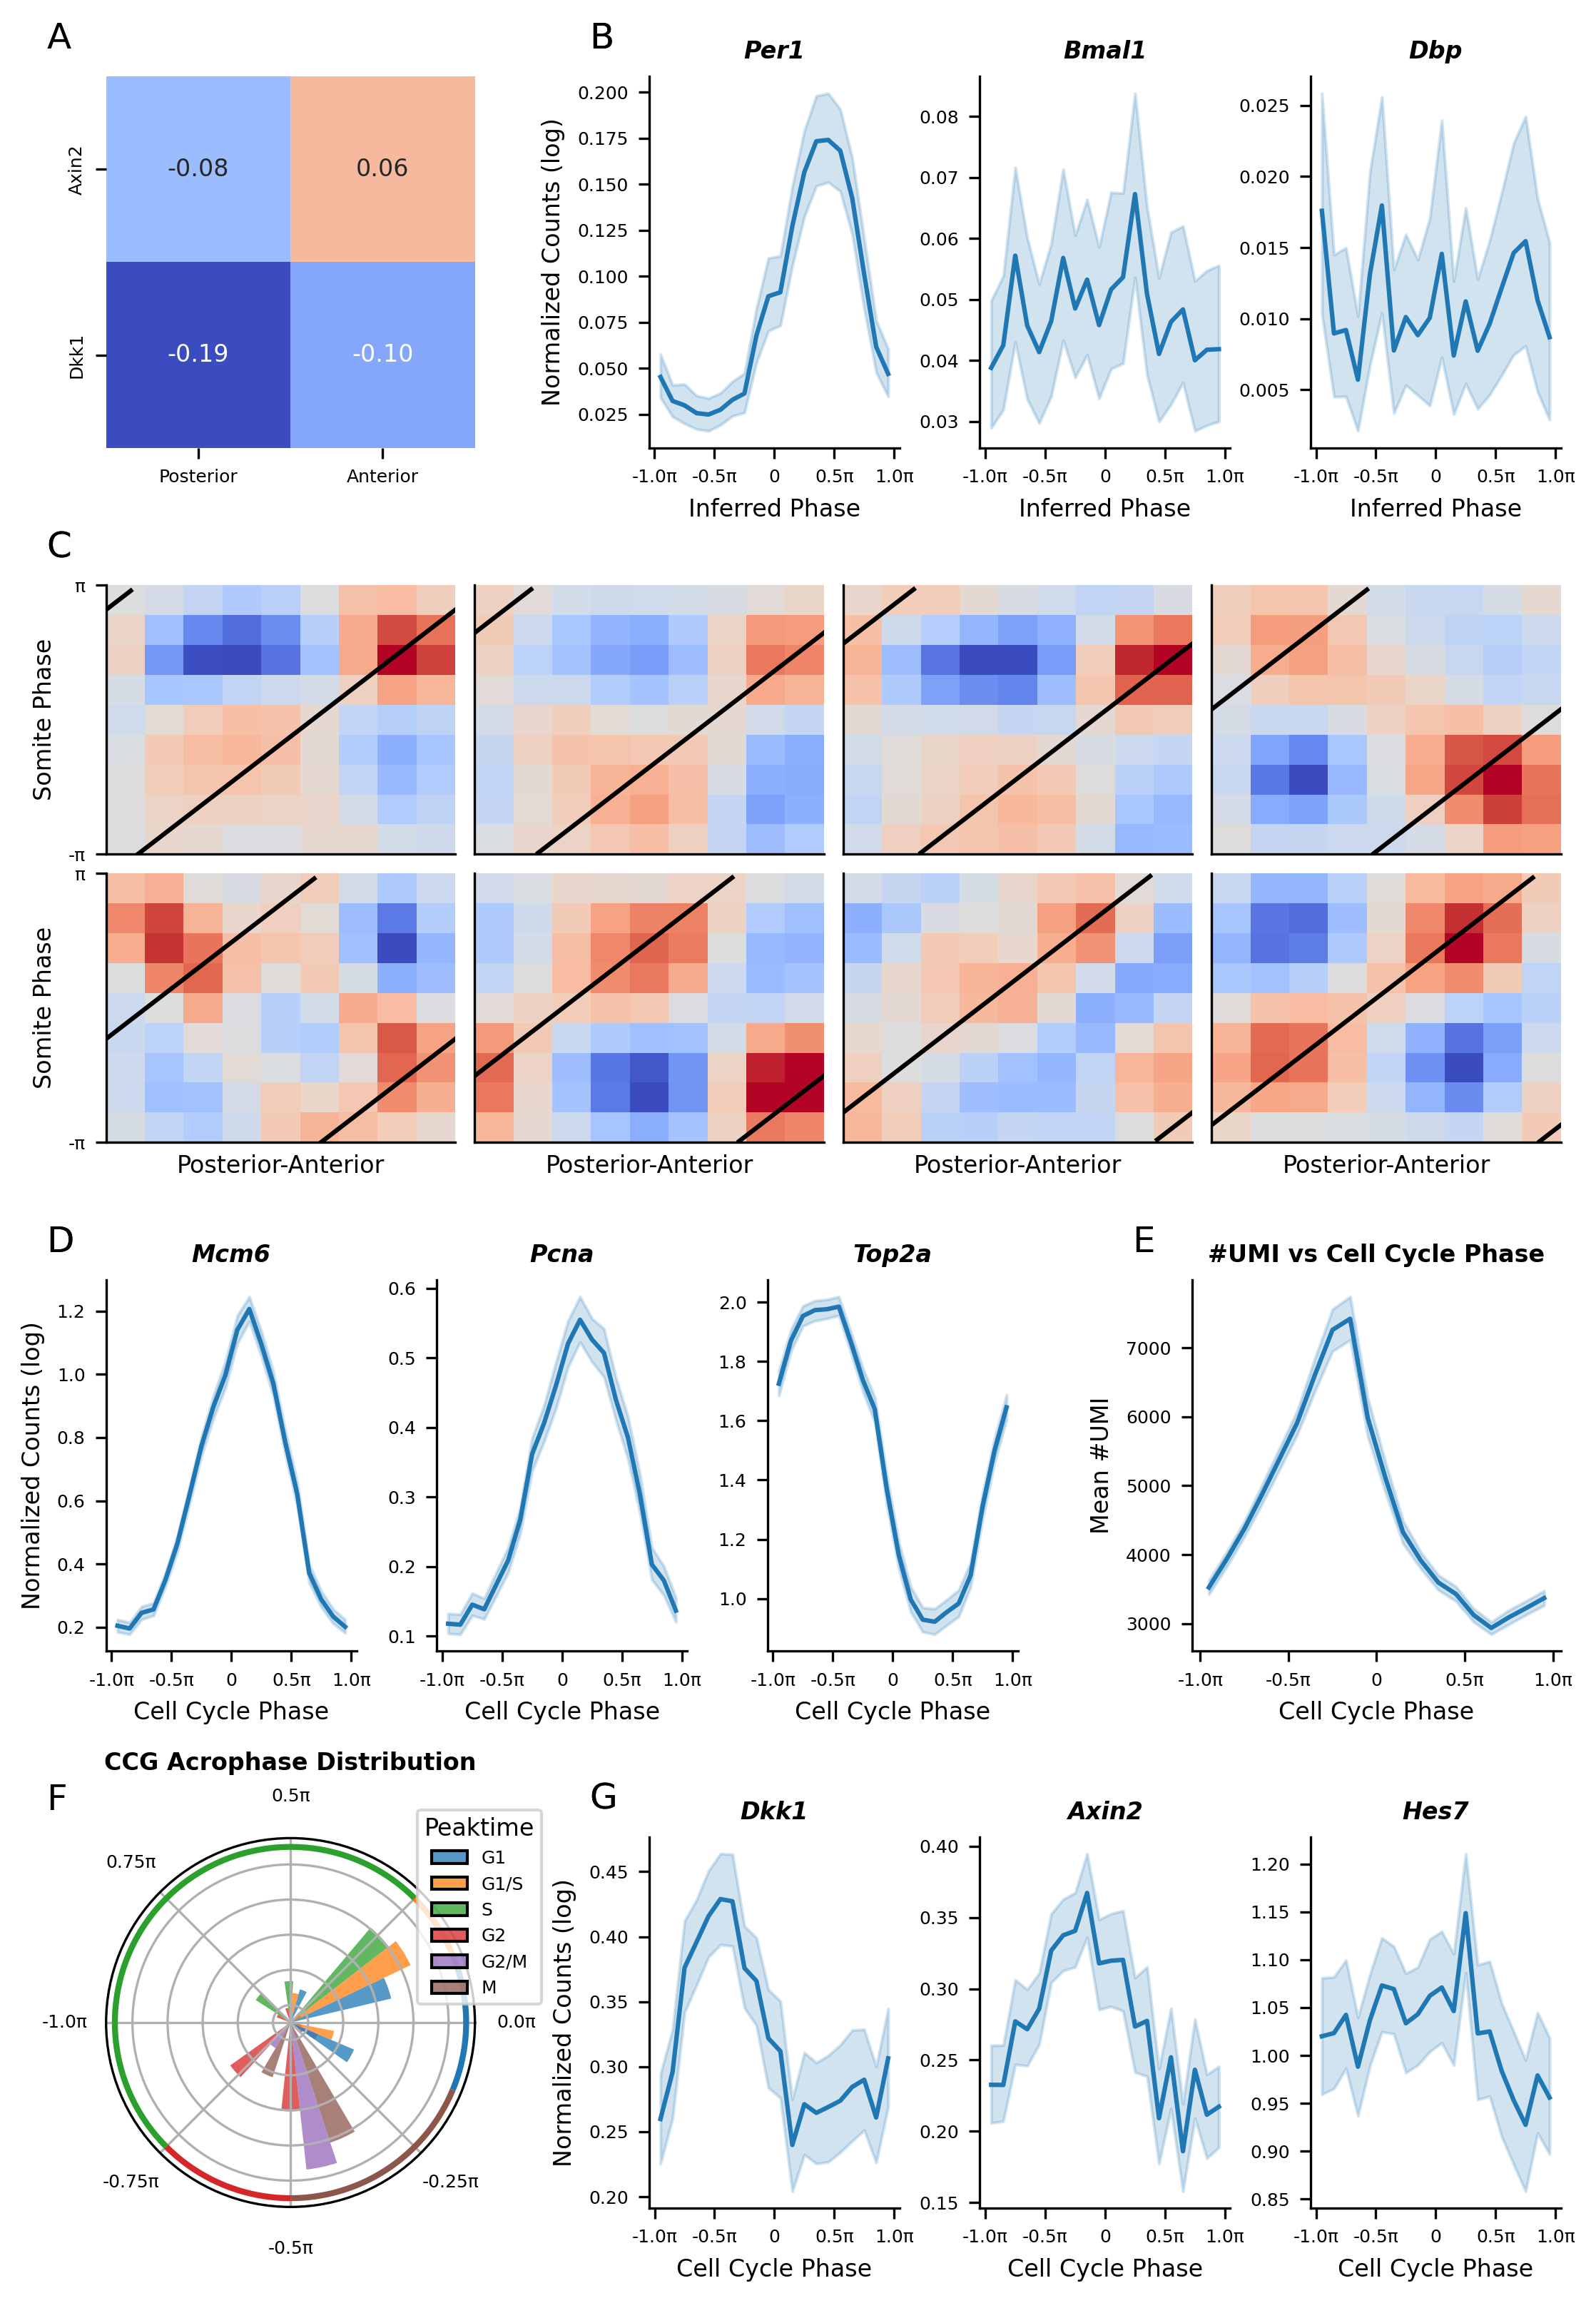

In [162]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic)
plot_helpers.save_figure(
    fig,
    axs,
    "figure_S10_somite_python",
    axs_pads={"C": [0.012, 0.008]},
    to_remove_vertically=[-0.02, -0.02, 0],
    mosaic=mosaic,
)  # wpad=0.012, hpad=0.008